<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Подключение-к-базе,-импорт-библиотек" data-toc-modified-id="Подключение-к-базе,-импорт-библиотек-0.1">Подключение к базе, импорт библиотек</a></span></li></ul></li><li><span><a href="#Задача-1" data-toc-modified-id="Задача-1-1">Задача 1</a></span></li><li><span><a href="#Задача-2" data-toc-modified-id="Задача-2-2">Задача 2</a></span><ul class="toc-item"><li><span><a href="#1." data-toc-modified-id="1.-2.1">1.</a></span></li><li><span><a href="#2." data-toc-modified-id="2.-2.2">2.</a></span></li></ul></li><li><span><a href="#Задача-3" data-toc-modified-id="Задача-3-3">Задача 3</a></span><ul class="toc-item"><li><span><a href="#1." data-toc-modified-id="1.-3.1">1.</a></span></li><li><span><a href="#2." data-toc-modified-id="2.-3.2">2.</a></span></li><li><span><a href="#3." data-toc-modified-id="3.-3.3">3.</a></span></li><li><span><a href="#4." data-toc-modified-id="4.-3.4">4.</a></span></li><li><span><a href="#5." data-toc-modified-id="5.-3.5">5.</a></span></li></ul></li><li><span><a href="#Задача-4" data-toc-modified-id="Задача-4-4">Задача 4</a></span></li></ul></div>

# Тестовое задание по SQL

Здесь представлены решения для пробных заданий по SQL. 

Для некоторых заданий была предоставлена тестовая база данных. Для заданий без доступа к базе данных составлялся аналог необходимых таблиц в отдельной "тестовой" базе данных.

### Подключение к базе, импорт библиотек

In [1]:
# Для создания своей БД
import sqlite3
import pandas as pd
import numpy as np
import random
from datetime import date, timedelta
con = sqlite3.connect('test.db')

In [2]:
# Подключение к существующей БД
from sqlalchemy import create_engine
import pandas as pd

db_config = {
    'user': user, # имя пользователя
    'pwd': pwd, # пароль
    'host': host,
    'port': port, # порт подключения
    'db': db # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}/{}?options=project%3Dep-wispy-shape-008661-pooler'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['db'],
)

engine = create_engine(connection_string) 

## Задача 1

В таблице total_sales содержится информация о сделках.

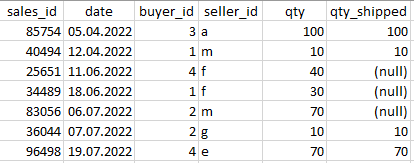
Требуется написать SQL запрос, который к каждой транзакции добавит:
- Дату первой сделки покупателя.
- Дату предыдущей сделки покупателя.
- Покажет общее количество товаров, купленных покупателем.
- Присвоить всем сделкам покупателя / продавца порядковый номер.

In [3]:
query = '''
SELECT *,
       FIRST_VALUE(date)
         OVER (
           PARTITION BY buyer_id
           ORDER BY date)                    AS first_order_date,
       LAG(date)
         OVER (
           PARTITION BY buyer_id
           ORDER BY date)                    AS previous_order_date,
       SUM(qty)
         OVER (
           PARTITION BY buyer_id)            AS total_qty,
       ROW_NUMBER()
         OVER (
           PARTITION BY buyer_id, seller_id) AS buyer_seller_orders_number
FROM   total_sales; 
'''
pd.read_sql_query(query, con=engine).head()

,sales_id,date,buyer_id,seller_id,qty,qty_shipped,first_order_date,previous_order_date,total_qty,buyer_seller_orders_number
0,774,2023-01-10,1,17,8,1,2023-01-10,None,37,2
1,457,2023-01-19,1,17,8,2,2023-01-10,2023-01-10,37,1
2,712,2023-01-27,1,18,6,7,2023-01-10,2023-01-19,37,1
3,174,2023-01-31,1,3,4,1,2023-01-10,2023-01-27,37,1
4,763,2023-01-31,1,13,0,1,2023-01-10,2023-01-31,37,1


## Задача 2

Схема базы данных

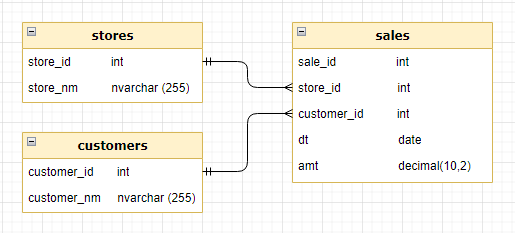

### 1.
Составьте запросы к базе, отвечающие на вопросы:

    a.Для каждого покупателя найдите магазин, в котором он совершил наибольшее количество покупок.

In [4]:
query = '''
WITH 

-- для каждого покупателя нумеруем магазины по убыванию количества покупок
customer_store_orders
     AS (SELECT customer_id,
                store_id,
                RANK()
                  OVER (
                    ORDER BY COUNT(sale_id) DESC) AS row_num
         FROM   sales
         GROUP  BY customer_id,
                   store_id)
                                     
-- объединяем таблицы customers и stores с таблицей из подзапроса customer_store_orders                
SELECT cs.customer_id,
       cust.customer_nm,
       cs.store_id,
       st.store_nm
FROM   customer_store_orders AS cs
       JOIN customers AS cust
         ON cust.customer_id = cs.customer_id
       JOIN stores AS st
         ON st.store_id = cs.store_id
WHERE  cs.row_num = 1;
'''
pd.read_sql_query(query, con=engine) 

,customer_id,customer_nm,store_id,store_nm
0,11,Customer 11,2,Store B


    b. Найдите всех покупателей, которые в каждом полном месяце этого года совершали не менее 3 покупок.

In [5]:
query = '''
WITH 

-- создадим фильтр для определения полных месяцев текущего года
date_filter 
    AS (SELECT DATE_TRUNC('year', CURRENT_DATE)::date AS year,
        DATE_TRUNC('month', CURRENT_DATE)::date - INTERVAL '1 day' AS full_month),

-- посчитаем общее количество покупок в каждом месяце
customer_sales_amt
     AS (SELECT customer_id,
                DATE_TRUNC('month', dt)::date AS month,
                COUNT(*) AS sales_amt,
                -- посчитаем, выполняется ли условие "не менее трёх покупок в каждом месяце"
                BOOL_AND(COUNT(sale_id) > 2) OVER (PARTITION BY customer_id) AS sales_amt_bool
         FROM   sales
         WHERE  dt BETWEEN (SELECT year FROM date_filter) AND (SELECT full_month FROM date_filter)
         GROUP BY customer_id, DATE_TRUNC('month', dt)::date),

-- выведем информацию о количестве месяцев, в которые покупатели совершали покупки (проверка условия о каждом месяце)   
customer_sales_true 
    AS (SELECT customer_id,
               count(*) AS month_count
         FROM   customer_sales_amt
         WHERE sales_amt_bool = 'True'
         GROUP BY customer_id)

SELECT customer_id
FROM customer_sales_true
WHERE month_count = (SELECT MAX(month_count) FROM customer_sales_true);
'''
pd.read_sql_query(query, con=engine).head()

,customer_id
0,1
1,2
2,3
3,4
4,5


### 2. 
Напишите запрос, формирующий ниже представленный отчет.
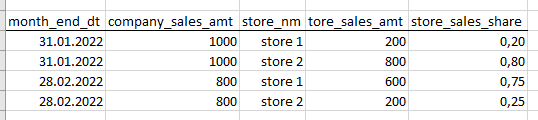

In [6]:
query = '''
SELECT  
       -- найдём последнюю дату месяца
       DISTINCT DATE_TRUNC('month', sl.dt)::date + INTERVAL '1 month - 1 day' AS month_end_dt,
       
       COUNT(amt)
         OVER (PARTITION BY DATE_TRUNC('month', sl.dt))  AS   company_sales_amt,
         
       st.store_nm ,
       
       COUNT(amt)
         OVER (PARTITION BY DATE_TRUNC('month', sl.dt), sl.store_id) AS store_sales_amt,
         
       COUNT(amt)
         OVER (PARTITION BY DATE_TRUNC('month', sl.dt), sl.store_id) /
         (COUNT(amt)
       OVER (PARTITION BY DATE_TRUNC('month', sl.dt)))::float AS   store_sales_share
       
FROM   sales AS sl
       JOIN stores AS st
         ON sl.store_id = st.store_id;
         '''
pd.read_sql_query(query, con=engine)

,month_end_dt,company_sales_amt,store_nm,store_sales_amt,store_sales_share
0,2023-01-31,30819,Store A,10180,0.330316
1,2023-01-31,30819,Store B,10442,0.338817
2,2023-01-31,30819,Store C,10197,0.330867
3,2023-02-28,28371,Store A,9468,0.333721
4,2023-02-28,28371,Store B,9513,0.335307
5,2023-02-28,28371,Store C,9390,0.330972
6,2023-03-31,22810,Store A,7636,0.334765
7,2023-03-31,22810,Store B,7666,0.336081
8,2023-03-31,22810,Store C,7508,0.329154


## Задача 3

### 1. 
В таблице calls хранятся данные всех звонков абонентов за отчетный месяц. В поле roaming указан факт нахождения абонента в роуминге во время звонка:

  *  1 - абонент был в роуминге;
   *  0 - абонент не был в роуминге.
   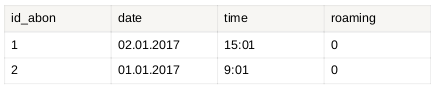
   
Напишите SQL запрос, определяющий уникальные id абонентов, которые хоть раз
звонили в роуминге за отчетный месяц.

In [7]:
query = '''
SELECT DISTINCT id_abon
FROM   calls
WHERE  roaming <> 0;
'''
pd.read_sql_query(query, con=engine).head()

,id_abon
0,42
1,29
2,4
3,34
4,41


### 2. 
В таблице abnt хранятся уникальные id всех абонентов, совершавших звонки за
отчетный месяц. В таблице roam хранятся уникальные id абонентов, которые
были в роуминге за отчетный месяц.
Напишите SQL запрос, результатом которого будут все id абонентов, которые не
были в роуминге в текущем месяце.

In [8]:
# создание необходимых таблиц

roam = {'id_abon' : random.sample(range(100), 30),
        'clc' : random.sample(range(1000),30)}
roam = pd.DataFrame(data=roam, index=range(0, 30))
roam.to_sql('roam', con, index=False, if_exists='replace')

abnt = {'id_abon' : random.sample(range(100), 30),
        'clc' : random.sample(range(1000), 30)}
abnt = pd.DataFrame(data=abnt, index=range(0, 30))
abnt.to_sql('abnt', con, index=False, if_exists='replace')

In [9]:
query = '''
SELECT id_abon
FROM   abnt
WHERE  id_abon NOT IN (SELECT id_abon
                       FROM   roam);
'''
pd.read_sql_query(query, con=con).head()

,id_abon
0,36
1,98
2,31
3,86
4,70


### 3.
В таблицах abnt и roam также хранятся данные о тратах абонентов. В таблице
abnt есть все начисления абонентов, в таблице roam начисления в роуминге.
Таблицы выглядят следующим образом:
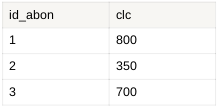

Напишите SQL запрос, который выведет всех абонентов с начислениями в
домашней сети больше 0.
Начисления в домашней сети= все начисления (abnt.clc) - начисления в роуминге
(roam.clc).

In [10]:
query = '''
SELECT abnt.id_abon,
       --используем coalesce для работы с null
       abnt.clc - COALESCE(roam.clc, 0) AS clc_home
FROM   abnt
       LEFT JOIN roam
         ON abnt.id_abon = roam.id_abon
WHERE  abnt.clc - COALESCE(roam.clc, 0) > 0;
'''
pd.read_sql_query(query, con=con).head()

,id_abon,clc_home
0,36,804
1,98,271
2,31,459
3,86,39
4,70,536


### 4.
Используя данные таблицы calls, выведите id всех абонентов, у которых было
больше 5 звонков в роуминге.

In [11]:
query = '''
WITH roam_calls_sum
     AS (SELECT id_abon,
                SUM(roaming) AS roam_calls
         FROM   calls
         GROUP  BY id_abon)
SELECT id_abon
FROM   roam_calls_sum
WHERE  roam_calls > 5;
'''
pd.read_sql_query(query, con=engine).head()

,id_abon
0,42
1,29
2,4
3,34
4,41


### 5. 
Используя данные таблицы calls, выведите периоды нахождения абонентов в
роуминге. Время пребывания в роуминге определяется непрерывной последовательностью звонков в роуминге.

In [12]:
query = '''
WITH 
-- выберем id и даты звонков в роуминге
roam_calls
     AS (SELECT id_abon,
                date::date AS dt
         FROM   calls
         WHERE  roaming = 1
         ORDER BY id_abon, date::date),
--создадим столбец с группой - для определения непрерывной последовательности
grp_date_table
     AS (SELECT id_abon,
                dt,
                dt  - (DENSE_RANK() OVER (
                                     PARTITION BY id_abon
                                     ORDER BY dt)) * (INTERVAL  '1 day')  AS grp
              FROM roam_calls)
              
-- выведем информацию,сгруппированную по столбцу grp             
SELECT id_abon,
       MIN(dt) AS roam_start,
       MAX(dt) AS roam_end
FROM   grp_date_table
GROUP  BY id_abon,
          grp
ORDER BY id_abon, roam_start; 
'''
pd.read_sql_query(query, con=engine).head(10)

,id_abon,roam_start,roam_end
0,1,2023-01-04,2023-01-04
1,1,2023-01-07,2023-01-13
2,1,2023-01-15,2023-01-16
3,1,2023-01-22,2023-01-22
4,1,2023-01-28,2023-01-29
5,2,2023-01-17,2023-01-18
6,2,2023-01-25,2023-01-25
7,2,2023-01-27,2023-01-27
8,3,2023-01-02,2023-01-02
9,3,2023-01-04,2023-01-04


## Задача 4

У вас есть две таблицы:
* t1 - данные по заявкам на Подбор кредита с сайта Сравни.ру;
* t2 - выгрузка банка о решениях по выдаче кредита.

Напишите SQL-запрос, содержащий всех пользователей, получивших кредит.

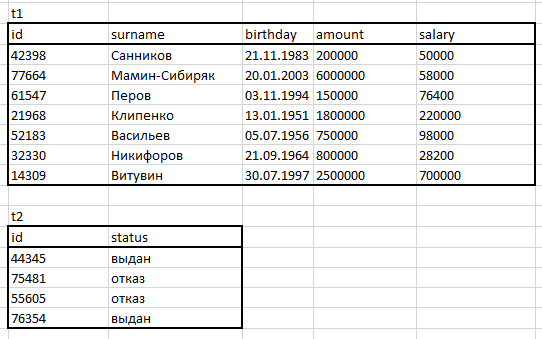

In [13]:
# создание таблиц

t1 = {'id' : random.sample(range(1000), 100), 
      'surname' : np.random.choice(['Иванов', 'Петров', 'Сидоров'], 100),
     'birthday' : np.random.choice(pd.date_range('1930-01-01', '2005-01-01'), 100),
     'amount' : np.random.randint(1, 10, 100),
     'salary' : np.random.randint(1, 10, 100)}
t1 = pd.DataFrame(data=t1, index=range(0, 100))
t1.to_sql('t1', con, index=False, if_exists='replace')


t2 = {'id' : random.sample(range(1000), 100), 
     'status' : np.random.choice(['выдан', 'отказ'], 100)}
t2 = pd.DataFrame(data=t2, index=range(0, 100))
t2.to_sql('t2', con, index=False, if_exists='replace')

In [14]:
query = '''
SELECT id,
       surname
FROM   t1
WHERE  id IN (SELECT id
         FROM   t2
         WHERE  status = 'выдан');
'''
pd.read_sql_query(query, con=con)

,id,surname
0,270,Иванов
1,362,Петров
2,558,Петров
3,640,Петров
4,850,Петров
5,156,Сидоров
